In [1]:
# rm(list = ls())
setwd("/mnt/c/git_repos/iORD_hepatitis/")
require(tidyverse)
require(data.table)
require(lubridate)
require(foreach)
require(doParallel)
require(randomcoloR)
require(tidyquant)
require(ggpubr)


Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The follo

### Load data

In [2]:
age_df <- fread("data/IORD_ASHep-UE_34_20230120_Attendances.csv") %>%
    mutate(AttendanceStartDate = as.Date(AttendanceStartDate),
           AttendanceEndDate = as.Date(AttendanceEndDate),
           LinkedBirthmonth = as.Date(LinkedBirthmonth)) %>%
    mutate(age_upon_presentation = time_length(AttendanceStartDate -
                                               LinkedBirthmonth, "year")) %>%
    mutate(age_upon_presentation = floor(age_upon_presentation)) %>% 
    mutate(age_group = case_when(age_upon_presentation < 7 ~ "<7",
                                 age_upon_presentation >= 6 & age_upon_presentation <= 15 ~ "7-15",
                                 age_upon_presentation >= 16 ~ ">15")) %>%
    filter(AttendanceStartDate < as.Date("2023-01-01")) %>%
    arrange(AttendanceStartDate)

micro_df <- fread("data/IORD_ASHep-UE_34_20230120_Microbiology.csv") %>%
    mutate(AttendanceStartDate = as.Date(AttendanceStartDate)) %>%
    left_join(age_df) %>%
    mutate(AttendanceMonth = cut(AttendanceStartDate, breaks = "month"),
           AttendanceTwoMonth = cut(AttendanceStartDate, breaks = "2 months")) %>%
    mutate(AttendanceStartDate = as.Date(AttendanceStartDate),
           AttendanceMonth = as.Date(AttendanceMonth),
           AttendanceTwoMonth = as.Date(AttendanceTwoMonth)) %>%
    filter(AttendanceMonth < as.Date("2023-01-01")) %>%
    rename(MicroTestName = TestName) %>%
    # Parse records
    mutate(BugName = ifelse(BatTestCode == "QADN" & ResultFull == "DETECTED", "Adenovirus", BugName)) %>%
    mutate(BugName = ifelse(grepl("Adenovirus", BugName, ignore.case = T), "Adenovirus", BugName)) %>%
    mutate(BugName = ifelse(BatTestCode %in% c('CV2G', 'CV2G2', 'CV2P', 'CV2Q', 'CV2V', 'RCV2Q', 'RCV2V') &
                            !grepl("not detected| |NONE|indeterminate", ResultFull, ignore.case = T),
                            "SARS-CoV-2", BugName)) %>%
    mutate(BugName = ifelse(grepl("SARS Coronavirus-2", BugName, ignore.case = T), "SARS-CoV-2", BugName)) %>%
    mutate(BugName = ifelse(grepl("Coronavirus", BugName, ignore.case = T), "Human coronavirus", BugName)) %>%
    mutate(BugName = ifelse(grepl("Staphy", BugName, ignore.case = T), "Staphylococcus", BugName)) %>%
    mutate(BugName = ifelse(grepl("Strep", BugName, ignore.case = T), "Streptococcus", BugName)) %>%
    mutate(BugName = ifelse(grepl("Candida", BugName, ignore.case = T), "Candida", BugName)) %>%
    mutate(BugName = ifelse(grepl("influenza a|influenza b|flu a|flu b", BugName, ignore.case = T), "Influenza", BugName)) %>%
    mutate(BugName = ifelse(grepl("Escherichia|E. coli", BugName, ignore.case = T), "Escherichia", BugName)) %>%
    mutate(BugName = ifelse(grepl("Enterococcus", BugName, ignore.case = T), "Enterococcus", BugName)) %>%
    mutate(BugName = ifelse(grepl("Klebsiella", BugName, ignore.case = T), "Klebsiella", BugName)) %>%
    mutate(BugName = ifelse(grepl("Acinetobacter", BugName, ignore.case = T), "Acinetobacter", BugName)) %>%
    mutate(BugName = ifelse(grepl("Bacillus", BugName, ignore.case = T), "Bacillus", BugName)) %>%
    mutate(BugName = ifelse(grepl("HAEMOPHILUS", BugName, ignore.case = T), "Haemophilus", BugName)) %>%
    mutate(BugName = ifelse(grepl("Parvimonas", BugName, ignore.case = T), "Parvimonas", BugName)) %>%
    mutate(BugName = ifelse(grepl("Burkholderia", BugName, ignore.case = T), "Burkholderia", BugName)) %>%
    mutate(BugName = ifelse(grepl("Micrococcus", BugName, ignore.case = T), "Micrococcus", BugName)) %>%
    mutate(BugName = ifelse(grepl("Proteus", BugName, ignore.case = T), "Proteus", BugName)) %>%
    mutate(BugName = ifelse(grepl("Lactococcus", BugName, ignore.case = T), "Lactococcus", BugName)) %>%
    mutate(BugName = ifelse(grepl("Rothia", BugName, ignore.case = T), "Rothia", BugName)) %>%
    mutate(BugName = ifelse(grepl("Salmonella", BugName, ignore.case = T), "Salmonella", BugName)) %>%
    mutate(BugName = ifelse(grepl("Actinomyces", BugName, ignore.case = T), "Actinomyces", BugName)) %>%
    mutate(BugName = ifelse(grepl("ANAEROCOCCUS", BugName, ignore.case = T), "Anaerococcus ", BugName)) %>%
    mutate(BugName = ifelse(grepl("Pseudomonas", BugName, ignore.case = T), "Pseudomonas", BugName)) %>%
    mutate(BugName = ifelse(grepl("Corynebacterium", BugName, ignore.case = T), "Corynebacterium", BugName)) %>%
    mutate(BugName = ifelse(grepl("Yersinia", BugName, ignore.case = T), "Yersinia", BugName)) %>%
    mutate(BugName = ifelse(grepl("ASPERGILLUS", BugName, ignore.case = T), "Aspergillus", BugName)) %>%
    mutate(BugName = ifelse(grepl("TURICELLA", BugName, ignore.case = T), "Turicella", BugName)) %>%
    mutate(BugName = ifelse(grepl("serratia", BugName, ignore.case = T), "Serratia", BugName)) %>%
    mutate(BugName = ifelse(grepl("moraxella", BugName, ignore.case = T), "Moraxella", BugName)) %>%
    mutate(BugName = ifelse(grepl("bacteroides", BugName, ignore.case = T), "Bacteroides", BugName)) %>%
    mutate(BugName = ifelse(grepl("shigella", BugName, ignore.case = T), "Shigella", BugName)) %>%
    mutate(BugName = ifelse(grepl("enterobacter", BugName, ignore.case = T), "Enterobacter", BugName)) %>%
    mutate(BugName = ifelse(grepl("GORDONIA", BugName, ignore.case = T), "Gordonia", BugName)) %>%
    mutate(BugName = ifelse(grepl("rhinovirus|enterovirus", BugName, ignore.case = T), "Rhinovirus/Enterovirus", BugName)) %>%
    mutate(BugName = ifelse(grepl("aerococcus", BugName, ignore.case = T), "Aerococcus", BugName)) %>%
    mutate(BugName = ifelse(grepl("aeromonas", BugName, ignore.case = T), "Aeromonas", BugName)) %>%
    mutate(BugName = ifelse(grepl("Raoultella", BugName, ignore.case = T), "Raoultella", BugName)) %>%
    mutate(BugName = ifelse(grepl("Brevibacterium", BugName, ignore.case = T), "Brevibacterium", BugName)) %>%
    mutate(BugName = ifelse(grepl("Prevotella", BugName, ignore.case = T), "Prevotella", BugName)) %>%
    mutate(BugName = ifelse(grepl("Trichophyton", BugName, ignore.case = T), "Trichophyton", BugName)) %>%
    mutate(BugName = ifelse(grepl("Parainfluenzavirus|parainfluenza virus", BugName, ignore.case = T), "Parainfluenzavirus", BugName)) %>%
    mutate(BugName = ifelse(grepl("Clostridium", BugName, ignore.case = T), "Clostridium", BugName)) %>%
    mutate(BugName = ifelse(grepl("Neisseria", BugName, ignore.case = T), "Neisseria", BugName)) %>%
    mutate(BugName = ifelse(grepl("Fusobacterium", BugName, ignore.case = T), "Fusobacterium", BugName)) %>%
    mutate(BugName = ifelse(grepl("Atopobium", BugName, ignore.case = T), "Atopobium", BugName)) %>%
    mutate(BugName = ifelse(grepl("Aggregatibacter", BugName, ignore.case = T), "Aggregatibacter", BugName)) %>%
    mutate(BugName = ifelse(grepl("Sphingobacterium", BugName, ignore.case = T), "Sphingobacterium", BugName)) %>%
    mutate(BugName = ifelse(grepl("Bradyrhizobium", BugName, ignore.case = T), "Bradyrhizobium", BugName)) %>%
    mutate(BugName = ifelse(grepl("Ruminococcus", BugName, ignore.case = T), "Ruminococcus", BugName)) %>%
    mutate(BugName = ifelse(grepl("Alcaligenes", BugName, ignore.case = T), "Alcaligenes", BugName)) %>%
    mutate(BugName = ifelse(grepl("Paracoccus", BugName, ignore.case = T), "Paracoccus", BugName)) %>%
    mutate(BugName = ifelse(grepl("HAEMATOBACTER", BugName, ignore.case = T), "Haematobacter", BugName)) %>%
    mutate(BugName = ifelse(grepl("Microbacterium", BugName, ignore.case = T), "Microbacterium", BugName)) %>%
    mutate(BugName = ifelse(grepl("Mycobacterium", BugName, ignore.case = T), "Mycobacterium", BugName)) %>%
    mutate(BugName = ifelse(grepl("Citrobacter", BugName, ignore.case = T), "Citrobacter", BugName)) %>%
    mutate(BugName = ifelse(grepl("Propionibacterium", BugName, ignore.case = T), "Cutibacterium", BugName)) %>%
    mutate(BugName = ifelse(grepl("Respiratory Syncytial Virus", BugName, ignore.case = T), "RSV", BugName)) %>%
    mutate(BugName = ifelse(grepl("Herpes|varicella", BugName, ignore.case = T), "Herpesvirus", BugName)) %>%
    mutate(BugName = ifelse(grepl("ACHROMOBACTER", BugName, ignore.case = T), "Achromobacter", BugName)) %>%
    mutate(BugName = ifelse(grepl("Kocuria", BugName, ignore.case = T), "Kocuria", BugName)) %>%
    mutate(BugName = ifelse(grepl("Roseomonas", BugName, ignore.case = T), "Roseomonas", BugName)) %>%
    mutate(BugName = ifelse(grepl("Morganella", BugName, ignore.case = T), "Morganella", BugName)) %>%
    mutate(BugName = ifelse(grepl("Listeria", BugName, ignore.case = T), "Listeria", BugName)) %>%
    mutate(BugName = ifelse(grepl("Chlamydia", BugName, ignore.case = T), "Cutibacterium", BugName)) %>%
    mutate(BugName = ifelse(grepl("Stenotrophomonas", BugName, ignore.case = T), "Stenotrophomonas", BugName)) %>%
    mutate(BugName = ifelse(grepl("Sphingomonas", BugName, ignore.case = T), "Sphingomonas", BugName)) %>%
    mutate(BugName = ifelse(grepl("VEILLONELLA", BugName, ignore.case = T), "Veillonella", BugName)) %>%
    mutate(BugName = ifelse(grepl("Finegoldia", BugName, ignore.case = T), "Finegoldia", BugName)) %>%
    mutate(BugName = ifelse(grepl("Pasteurella", BugName, ignore.case = T), "Pasteurella", BugName)) %>%
    mutate(BugName = ifelse(grepl("Campylobacter", BugName, ignore.case = T), "Campylobacter", BugName)) %>%
    mutate(BugName = ifelse(grepl("Rhizobium", BugName, ignore.case = T), "Rhizobium", BugName)) %>%
    mutate(BugName = ifelse(grepl("PEPTONIPHILUS", BugName, ignore.case = T), "Peptoniphilus", BugName)) %>%
    mutate(BugName = ifelse(grepl("Brevundimonas", BugName, ignore.case = T), "Brevundimonas", BugName)) %>%
    mutate(BugName = ifelse(grepl("GEMELLA", BugName, ignore.case = T), "Gemella", BugName)) %>%
    mutate(BugName = ifelse(grepl("cocci|colonies|aerobic|anaerobic|anaerobes|gram positive|gram negative|Fungal", BugName, ignore.case = T), "ambiguous", BugName))

test_df <- fread("data/IORD_ASHep-UE_34_20230120_LIMS.csv") %>%
    mutate(CollectionDateTime = as.Date(CollectionDateTime),
           AttendanceStartDate = as.Date(AttendanceStartDate)) %>%
    filter(AttendanceStartDate < as.Date("2023-01-01"))

test_parsed <- test_df %>%
    distinct(ClusterID, AttendanceStartDate, TestName, .keep_all = T) %>%
    separate(RefRange, into = c("LLN", "ULN"), sep = "-") %>%
    mutate(ULN = as.numeric(ULN)) %>%
    select(-CollectionDateTime, -ReceiveDateTime) %>%
    mutate(Value = as.numeric(Value)) %>%
    mutate(Value = ifelse(is.na(Value), 0, Value)) %>%
    mutate(value_class = case_when(Value <= ULN ~ "Normal <= ULN",
                                 Value > ULN & Value <= 2 * ULN ~ "Mild (1-2x ULN)",
                                 Value > 2 * ULN & Value <= 5 * ULN  ~ "Moderate (2-5x ULN)",
                                 Value > 5 * ULN ~ "Severe (>5x ULN)")) %>%
    mutate(value_class = ifelse(TestName == "ALBUMIN" & Value < LLN, "<LLN (albumin)", value_class)) %>%
    mutate(value_class = ifelse(TestName == "ALBUMIN" & Value >= LLN, "Normal (albumin)", value_class)) %>%
    mutate(value_class = factor(value_class, c("Normal <= ULN", 
                                               "Mild (1-2x ULN)", 
                                               "Moderate (2-5x ULN)",
                                               "Severe (>5x ULN)",
                                               "Normal (albumin)", 
                                               "<LLN (albumin)"))) 

# Admissions
admission_df <- fread("data/IORD_ASHep-UE_34_20230120_InpatientSpells.csv") %>%
    filter(AttendanceStartDate < as.Date("2023-01-01")) %>%
    mutate(AttendanceStartDate = as.Date(AttendanceStartDate))

admit_attendance_df <- age_df %>%
    left_join(admission_df) %>%
    distinct(ClusterID, AttendanceStartDate, .keep_all = T) %>%
    mutate(LinkedDeathdate = ifelse(LinkedDeathdate == "NULL", "2030-01-14 14:00:08.433", LinkedDeathdate),
           duration = as.Date(DischargeDate) - as.Date(AdmissionDate)) %>%
    mutate(AttendanceEndDate = ifelse(is.na(AttendanceEndDate), as.Date(DischargeDate), as.Date(AttendanceEndDate))) %>%
    mutate(LinkedDeathdate = as.Date(LinkedDeathdate)) %>%
    mutate(is_admitted = ifelse(is.na(AdmissionDate), F, T),
           is_icu = ifelse(SpellIncludesCriticalCareAdmission == 1, T, F),
           is_death = ifelse(LinkedDeathdate >= AttendanceStartDate &
                             LinkedDeathdate <= AttendanceEndDate, T, F)) %>%
    mutate(is_icu = ifelse(is.na(is_icu), F, T))

# all_months <- cut(seq(as.Date("2016-03-01"), as.Date("2022-12-01"), by = "1 month"), breaks = "1 month")
# all_months_df <- tibble(AttendanceMonth = rep(as.Date(all_months),3),
#                         age_group = c(rep("<7", length(all_months)),
#                                       rep("7-15", length(all_months)),
#                                       rep(">15", length(all_months))))

Joining with `by = join_by(ClusterID, AttendanceStartDate)`
Warning message in left_join(., age_df):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 93 of `x` matches multiple rows in `y`.
ℹ Row 659231 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship = "many-to-many"` to silence this warning.”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `ULN = as.numeric(ULN)`.
Caused by warning:
! NAs introduced by coercion”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `Value = as.numeric(Value)`.
Caused by warning:
! NAs introduced by coercion”
Joining with `by = join_by(ClusterID, AttendanceStartDate)`
Warning message in left_join(., admission_df):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 18 of `x` matches multiple rows in `y`.
ℹ Row 140318 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationshi

In [3]:
micro_df %>% 
    group_by(BugName) %>%
    summarise(n = n()) %>%
    arrange(desc(n)) %>%
    filter(grepl("SARS", BugName))

micro_df %>% 
    group_by(BugName) %>%
    summarise(n = n()) %>%
    arrange(desc(n)) %>%
    filter(grepl("virus|influenza", BugName, ignore.case = T))

bugs_of_interest <- micro_df %>% 
    group_by(BugName) %>%
    summarise(n = n()) %>%
    filter(!(BugName %in% c("NULL", "ambiguous"))) %>%
    filter(grepl("virus|influenza|SARS", BugName, ignore.case = T)) %>%
    arrange(desc(n)) %>%
    head(7)

bugs_of_interest

BugName,n
<chr>,<int>
SARS-CoV-2,128911


BugName,n
<chr>,<int>
Influenza,2162
Rhinovirus/Enterovirus,538
Herpesvirus,346
Adenovirus,203
Human coronavirus,93
Parainfluenzavirus,93
Metapneumovirus DETECTED,77
Human Bocavirus DETECTED,7
Norovirus GII DETECTED by PCR,6


BugName,n
<chr>,<int>
SARS-CoV-2,128911
Influenza,2162
Rhinovirus/Enterovirus,538
Herpesvirus,346
Adenovirus,203
Human coronavirus,93
Parainfluenzavirus,93


In [4]:
test_df %>% distinct(TestName)

TestName
<chr>
ALBUMIN
CRP
EOSINOPHILS
WHITE CELLS
PLATELETS
ALK.PHOSPHATASE
ALT
MONOCYTES
NEUTROPHILS


### Adenovirus

In [27]:
bug_tests

BatTestCode
<chr>
RPCR
EPCR
OPCR
QADN
RGAS
LRTP


[1] "adenovirus"


`summarise()` has grouped output by 'ClusterID'. You can override using the `.groups` argument.
Joining with `by = join_by(ClusterID, AttendanceStartDate)`
`summarise()` has grouped output by 'TestName'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'TestName', 'value_class'. You can override using the `.groups` argument.
Joining with `by = join_by(TestName, bug_pos)`
Warning message in geom_text(data = stat_test_df, aes(x = 3, y = 0.9, group = TestName, :
“Ignoring unknown aesthetics: fill”


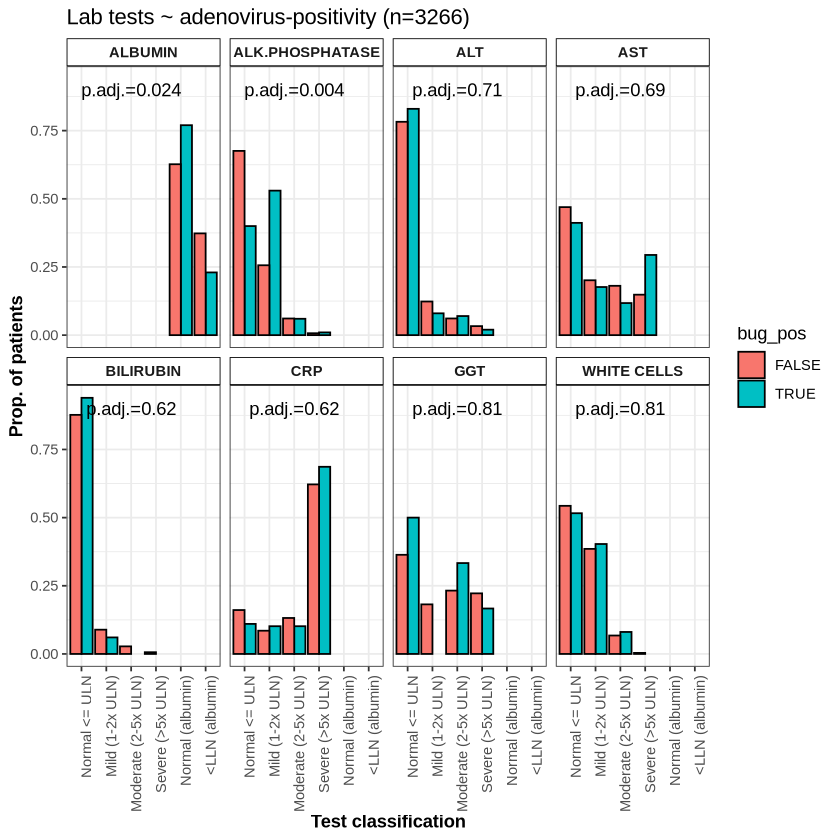

In [28]:
bug_name <- "adenovirus"
print(bug_name)

# Get only tests that are relevant to bug
bug_tests <- micro_df %>%
    filter(grepl(bug_name, BugName, ignore.case = T)) %>%
    distinct(BatTestCode)

micro_filt <- micro_df %>%
    filter(BatTestCode %in% bug_tests$BatTestCode) %>%
    mutate(bug_pos = ifelse(grepl(bug_name, BugName, ignore.case = T), T, F),
           is_outbreak = ifelse(AttendanceMonth < as.Date("2022-08-01") & AttendanceMonth > as.Date("2021-10-01"),
                                T, F))

# Code multiple tests
multi_filt <- micro_filt %>%
    group_by(ClusterID, AttendanceStartDate) %>%
    summarise(n_pos = sum(bug_pos)) %>%
    mutate(bug_pos = ifelse(n_pos > 0, T, F))

micro_test <- multi_filt %>%
    inner_join(test_parsed) %>%
    mutate(log_value = log10(Value + 0.00001))

micro_test_filt <- micro_test %>%
    filter(TestName %in% c("ALK.PHOSPHATASE", "ALT", "AST",
                           "BILIRUBIN", "GGT","CRP", 
                           "WHITE CELLS", "ALBUMIN"))

# Get total number of distinct patients
count_df <- micro_test_filt %>%
    group_by(TestName, bug_pos) %>%
    summarise(n_total = n())

plot_df <- micro_test_filt %>%
    group_by(TestName, value_class, bug_pos) %>%
    summarise(n = n()) %>%
    left_join(count_df) %>%
    mutate(prop = n / n_total) %>%
    arrange(desc(bug_pos)) 

# Get cont tables
cont_tables <- xtabs(data = plot_df, n ~ value_class + bug_pos + TestName)

# Filter cont tables
to_keep1 <- colSums(apply(cont_tables, 3, rowSums) != 0) > 1
to_keep2 <- colSums(apply(cont_tables, 3, colSums) != 0) == 2
to_keep <- to_keep1 & to_keep2
cont_tables_filt <- cont_tables[, , to_keep]

# Run Fisher exact tests
test_res <- apply(cont_tables_filt, 3, function(x) {fisher.test(x, simulate.p.value = T)})

test_morsels <- foreach(i = seq(dim(cont_tables_filt)[3])) %do% {
    test_name <- names(test_res)[i]
    cont_table <- test_res[[i]]
    tibble(TestName = test_name, p.value = cont_table$p.value)
}

stat_test_df <- bind_rows(test_morsels) %>%
    mutate(p.adj = p.adjust(p.value, method = "BH")) %>%
    mutate(p.adj = signif(p.adj, 2))

# Count number of patients
n_patients <- deframe(micro_test_filt %>%
    distinct(ClusterID, AttendanceStartDate) %>%
    nrow())

# Parse bug name
bug_name_parsed <- gsub("/| ", "_", bug_name)

# Plot barplot
plot_df %>%
    mutate(TestName = factor(TestName, levels = c("MONOCYTES", "ALK.PHOSPHATASE", "ALT", "AST",
                                                  "BILIRUBIN", "GGT","CRP", 
                                                  "WHITE CELLS", "ALBUMIN"))) %>%
    ggplot(aes(x = value_class, y = prop, fill = bug_pos)) +
    geom_bar(stat = "identity", 
             position = position_dodge(preserve = "single"),
             color = "black") +
    facet_wrap(~TestName, nrow = 2) +
    geom_text(data = stat_test_df, aes(x = 3, y = 0.9, group = TestName, fill = NA, label = str_glue("p.adj.={p.adj}"))) +
    theme_bw() +
    theme(strip.background = element_rect(color = "black", fill = "white"),
          strip.text = element_text(face = "bold"),
          axis.title = element_text(face = "bold"),
          axis.text.x = element_text(angle = 90, hjust = 1)) +
    labs(x = "Test classification", y = "Prop. of patients",
         title = str_glue("Lab tests ~ {bug_name_parsed}-positivity (n={n_patients})"))

ggsave(str_glue("results/virus_test_characteristics/{bug_name_parsed}_infection_test_characteristics.pdf"), dpi = 300, width = 10, height = 6)

### Rhinovirus/Enterovirus

[1] "Rhinovirus/Enterovirus"


`summarise()` has grouped output by 'ClusterID'. You can override using the `.groups` argument.
Joining with `by = join_by(ClusterID, AttendanceStartDate)`
`summarise()` has grouped output by 'TestName'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'TestName', 'value_class'. You can override using the `.groups` argument.
Joining with `by = join_by(TestName, bug_pos)`
Warning message in geom_text(data = stat_test_df, aes(x = 3, y = 0.9, group = TestName, :
“Ignoring unknown aesthetics: fill”


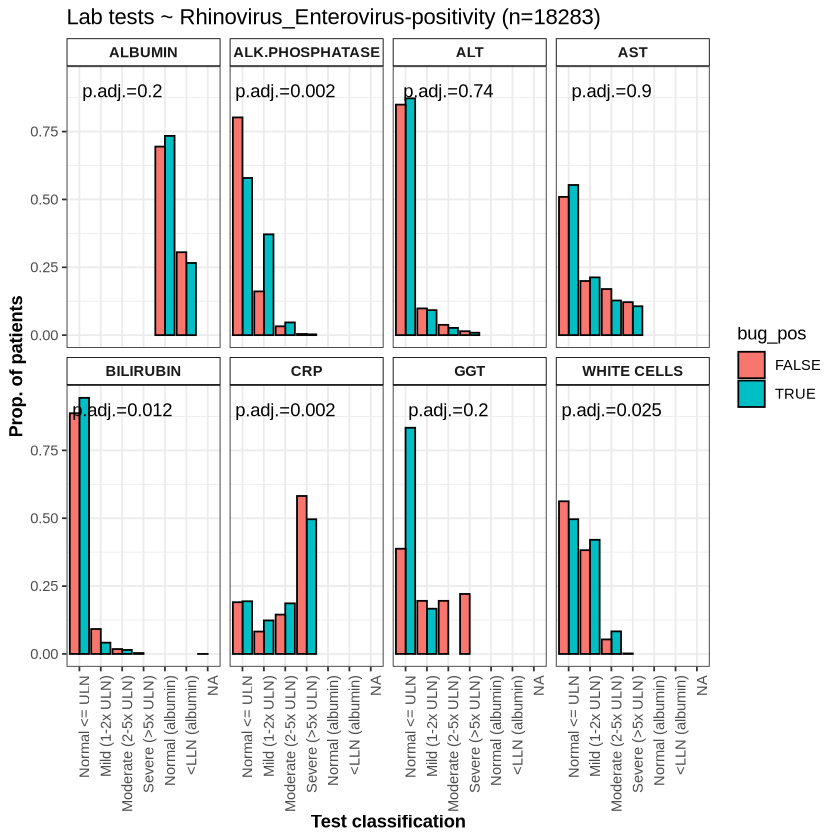

In [29]:
bug_name <- "Rhinovirus/Enterovirus"
print(bug_name)

# Get only tests that are relevant to bug
bug_tests <- micro_df %>%
    filter(grepl(bug_name, BugName, ignore.case = T)) %>%
    distinct(BatTestCode)

micro_filt <- micro_df %>%
    filter(BatTestCode %in% bug_tests$BatTestCode) %>%
    mutate(bug_pos = ifelse(grepl(bug_name, BugName, ignore.case = T), T, F),
           is_outbreak = ifelse(AttendanceMonth < as.Date("2022-08-01") & AttendanceMonth > as.Date("2021-10-01"),
                                T, F))

# Code multiple tests
multi_filt <- micro_filt %>%
    group_by(ClusterID, AttendanceStartDate) %>%
    summarise(n_pos = sum(bug_pos)) %>%
    mutate(bug_pos = ifelse(n_pos > 0, T, F))

micro_test <- multi_filt %>%
    inner_join(test_parsed) %>%
    mutate(log_value = log10(Value + 0.00001))

micro_test_filt <- micro_test %>%
    filter(TestName %in% c("ALK.PHOSPHATASE", "ALT", "AST",
                           "BILIRUBIN", "GGT","CRP", 
                           "WHITE CELLS", "ALBUMIN"))

# Get total number of distinct patients
count_df <- micro_test_filt %>%
    group_by(TestName, bug_pos) %>%
    summarise(n_total = n())

plot_df <- micro_test_filt %>%
    group_by(TestName, value_class, bug_pos) %>%
    summarise(n = n()) %>%
    left_join(count_df) %>%
    mutate(prop = n / n_total) %>%
    arrange(desc(bug_pos)) 

# Get cont tables
cont_tables <- xtabs(data = plot_df, n ~ value_class + bug_pos + TestName)

# Filter cont tables
to_keep1 <- colSums(apply(cont_tables, 3, rowSums) != 0) > 1
to_keep2 <- colSums(apply(cont_tables, 3, colSums) != 0) == 2
to_keep <- to_keep1 & to_keep2
cont_tables_filt <- cont_tables[, , to_keep]

# Run Fisher exact tests
test_res <- apply(cont_tables_filt, 3, function(x) {fisher.test(x, simulate.p.value = T)})

test_morsels <- foreach(i = seq(dim(cont_tables_filt)[3])) %do% {
    test_name <- names(test_res)[i]
    cont_table <- test_res[[i]]
    tibble(TestName = test_name, p.value = cont_table$p.value)
}

stat_test_df <- bind_rows(test_morsels) %>%
    mutate(p.adj = p.adjust(p.value, method = "BH")) %>%
    mutate(p.adj = signif(p.adj, 2))

# Count number of patients
n_patients <- deframe(micro_test_filt %>%
    distinct(ClusterID, AttendanceStartDate) %>%
    nrow())

# Parse bug name
bug_name_parsed <- gsub("/| ", "_", bug_name)

# Plot barplot
plot_df %>%
    mutate(TestName = factor(TestName, levels = c("MONOCYTES", "ALK.PHOSPHATASE", "ALT", "AST",
                                                  "BILIRUBIN", "GGT","CRP", 
                                                  "WHITE CELLS", "ALBUMIN"))) %>%
    ggplot(aes(x = value_class, y = prop, fill = bug_pos)) +
    geom_bar(stat = "identity", 
             position = position_dodge(preserve = "single"),
             color = "black") +
    facet_wrap(~TestName, nrow = 2) +
    geom_text(data = stat_test_df, aes(x = 3, y = 0.9, group = TestName, fill = NA, label = str_glue("p.adj.={p.adj}"))) +
    theme_bw() +
    theme(strip.background = element_rect(color = "black", fill = "white"),
          strip.text = element_text(face = "bold"),
          axis.title = element_text(face = "bold"),
          axis.text.x = element_text(angle = 90, hjust = 1)) +
    labs(x = "Test classification", y = "Prop. of patients",
         title = str_glue("Lab tests ~ {bug_name_parsed}-positivity (n={n_patients})"))

ggsave(str_glue("results/virus_test_characteristics/{bug_name_parsed}_infection_test_characteristics.pdf"), dpi = 300, width = 8, height = 6)

In [19]:
# set.seed(66)
# for(bug_name in bugs_of_interest$BugName) {
#     bug_name <- "adenovirus"
#     print(bug_name)
#     # Get only tests that are relevant to bug
#     bug_tests <- micro_df %>%
#         filter(grepl(bug_name, BugName, ignore.case = T)) %>%
#         distinct(BatTestCode)
    
#     micro_filt <- micro_df %>%
#         filter(BatTestCode %in% bug_tests$BatTestCode) %>%
#         mutate(bug_pos = ifelse(grepl(bug_name, BugName, ignore.case = T), T, F),
#                is_outbreak = ifelse(AttendanceMonth < as.Date("2022-08-01") & AttendanceMonth > as.Date("2021-10-01"),
#                                     T, F))
    
#     # Code multiple tests
#     multi_filt <- micro_filt %>%
#         group_by(ClusterID, AttendanceStartDate) %>%
#         summarise(n_pos = sum(bug_pos)) %>%
#         mutate(bug_pos = ifelse(n_pos > 0, T, F))
    
#     micro_test <- multi_filt %>%
#         inner_join(test_parsed) %>%
#         mutate(log_value = log10(Value + 0.00001))

#     micro_test_filt <- micro_test %>%
#         filter(TestName %in% c("ALK.PHOSPHATASE", "ALT", "AST",
#                                "BILIRUBIN", "GGT","CRP", 
#                                "WHITE CELLS", "ALBUMIN"))
    
#     # Get total number of distinct patients
#     count_df <- micro_test_filt %>%
#         group_by(TestName, bug_pos) %>%
#         summarise(n_total = n())

#     plot_df <- micro_test_filt %>%
#         group_by(TestName, value_class, bug_pos) %>%
#         summarise(n = n()) %>%
#         left_join(count_df) %>%
#         mutate(prop = n / n_total) %>%
#         arrange(desc(bug_pos)) 
    
#     # Get cont tables
#     cont_tables <- xtabs(data = plot_df, n ~ value_class + bug_pos + TestName)

#     # Filter cont tables
#     to_keep1 <- colSums(apply(cont_tables, 3, rowSums) != 0) > 1
#     to_keep2 <- colSums(apply(cont_tables, 3, colSums) != 0) == 2
#     to_keep <- to_keep1 & to_keep2
#     cont_tables_filt <- cont_tables[, , to_keep]
    
#     # Run Fisher exact tests
#     test_res <- apply(cont_tables_filt, 3, function(x) {fisher.test(x, simulate.p.value = T)})
    
#     test_morsels <- foreach(i = seq(dim(cont_tables_filt)[3])) %do% {
#         test_name <- names(test_res)[i]
#         cont_table <- test_res[[i]]
#         tibble(TestName = test_name, p.value = cont_table$p.value)
#     }

#     stat_test_df <- bind_rows(test_morsels) %>%
#         mutate(p.adj = p.adjust(p.value, method = "BH")) %>%
#         mutate(p.adj = signif(p.adj, 2))

#     # Count number of patients
#     n_patients <- deframe(micro_test_filt %>%
#         distinct(ClusterID, AttendanceStartDate) %>%
#         nrow())
    
#     # Parse bug name
#     bug_name_parsed <- gsub("/| ", "_", bug_name)
    
#     # Plot barplot
#     plot_df %>%
#         ggplot(aes(x = value_class, y = prop, fill = bug_pos)) +
#         geom_bar(stat = "identity", 
#                  position = position_dodge(preserve = "single"),
#                  color = "black") +
#         facet_wrap(~TestName) +
#         geom_text(data = stat_test_df, aes(x = 3, y = 0.9, group = TestName, fill = NA, label = str_glue("p.adj.={p.adj}"))) +
#         theme_bw() +
#         theme(strip.background = element_rect(color = "black", fill = "white"),
#               strip.text = element_text(face = "bold"),
#               axis.title = element_text(face = "bold"),
#               axis.text.x = element_text(angle = 90, hjust = 1),
#               panel.grid = element_blank()) +
#         labs(x = "Test classification", y = "Prop. of patients",
#              title = str_glue("Lab tests ~ {bug_name_parsed}-positivity (n={n_patients})"))

#     ggsave(str_glue("results/virus_test_characteristics/{bug_name_parsed}_infection_test_characteristics.pdf"), dpi = 300, width = 8, height = 6)
# }

### For Albumin

In [20]:
    # bug_name <- "Rhinovirus/Enterovirus"
    # print(bug_name)
    # # Get only tests that are relevant to bug
    # bug_tests <- micro_df %>%
    #     filter(grepl(bug_name, BugName, ignore.case = T)) %>%
    #     distinct(BatTestCode)
    
    # micro_filt <- micro_df %>%
    #     filter(BatTestCode %in% bug_tests$BatTestCode) %>%
    #     mutate(bug_pos = ifelse(grepl(bug_name, BugName, ignore.case = T), T, F),
    #            is_outbreak = ifelse(AttendanceMonth < as.Date("2022-08-01") & AttendanceMonth > as.Date("2021-10-01"),
    #                                 T, F))
    
    # # Code multiple tests
    # multi_filt <- micro_filt %>%
    #     group_by(ClusterID, AttendanceStartDate) %>%
    #     summarise(n_pos = sum(bug_pos)) %>%
    #     mutate(bug_pos = ifelse(n_pos > 0, T, F))
    
    # micro_test <- multi_filt %>%
    #     inner_join(test_parsed) %>%
    #     mutate(log_value = log10(Value + 0.00001))

    # micro_test_filt <- micro_test %>%
    #     filter(TestName == "ALBUMIN") %>%
    #     mutate(value_class = ifelse(Value < LLN, "<LLN", "Normal")) %>%
    #     mutate(value_class = factor(value_class, c("Normal", "<LLN")))
    
    # # Get total number of distinct patients
    # count_df <- micro_test_filt %>%
    #     group_by(bug_pos) %>%
    #     summarise(n_total = n())

    # plot_df <- micro_test_filt %>%
    #     group_by(value_class, bug_pos, TestName) %>%
    #     summarise(n = n()) %>%
    #     left_join(count_df) %>%
    #     mutate(prop = n / n_total) %>%
    #     arrange(desc(bug_pos)) 
    
    # # Get cont tables
    # cont_table <- xtabs(data = plot_df, n ~ value_class + bug_pos + TestName)
    # cont_table
    # # # Filter cont tables
    # # to_keep1 <- colSums(apply(cont_tables, 3, rowSums) != 0) > 1
    # # to_keep2 <- colSums(apply(cont_tables, 3, colSums) != 0) == 2
    # # to_keep <- to_keep1 & to_keep2
    # # cont_tables_filt <- cont_tables[, , to_keep]
    
    # # # Run Fisher exact tests
    # # test_res <- apply(cont_tables_filt, 3, function(x) {fisher.test(x, simulate.p.value = T)})
    
    # # test_morsels <- foreach(i = seq(dim(cont_tables_filt)[3])) %do% {
    # #     test_name <- names(test_res)[i]
    # #     cont_table <- test_res[[i]]
    # #     tibble(TestName = test_name, p.value = cont_table$p.value)
    # # }

    # # stat_test_df <- bind_rows(test_morsels) %>%
    # #     mutate(p.adj = p.adjust(p.value, method = "BH")) %>%
    # #     mutate(p.adj = signif(p.adj, 2))

    # # # Count number of patients
    # # n_patients <- deframe(micro_test_filt %>%
    # #     distinct(ClusterID, AttendanceStartDate) %>%
    # #     nrow())
    
    # # # Parse bug name
    # # bug_name_parsed <- gsub("/| ", "_", bug_name)
    
    # # # Plot barplot
    # # plot_df %>%
    # #     ggplot(aes(x = value_class, y = prop, fill = bug_pos)) +
    # #     geom_bar(stat = "identity", 
    # #              position = position_dodge(preserve = "single"),
    # #              color = "black") +
    # #     facet_wrap(~TestName) +
    # #     geom_text(data = stat_test_df, aes(x = 3, y = 0.9, group = TestName, fill = NA, label = str_glue("p.adj.={p.adj}"))) +
    # #     theme_bw() +
    # #     theme(strip.background = element_rect(color = "black", fill = "white"),
    # #           strip.text = element_text(face = "bold"),
    # #           axis.title = element_text(face = "bold"),
    # #           axis.text.x = element_text(angle = 90, hjust = 1)) +
    # #     labs(x = "Test classification", y = "Prop. of patients",
    # #          title = str_glue("Lab tests ~ {bug_name_parsed}-positivity (n={n_patients})"))

    # # ggsave(str_glue("results/virus_test_characteristics/{bug_name_parsed}_infection_test_characteristics.pdf"), dpi = 300, width = 8, height = 6)

In [22]:
# for(bug_name in bugs_of_interest$BugName) {
# #     bug_name <- "adenovirus"
#     print(bug_name)
#     # Get only tests that are relevant to bug
#     bug_tests <- micro_df %>%
#         filter(grepl(bug_name, BugName, ignore.case = T)) %>%
#         distinct(BatTestCode)
    
#     micro_filt <- micro_df %>%
#         filter(BatTestCode %in% bug_tests$BatTestCode) %>%
#         mutate(bug_pos = ifelse(grepl(bug_name, BugName, ignore.case = T), T, F),
#                is_outbreak = ifelse(AttendanceMonth < as.Date("2022-08-01") & AttendanceMonth > as.Date("2021-10-01"),
#                                     T, F))
    
#     # Code multiple tests
#     multi_filt <- micro_filt %>%
#         group_by(ClusterID, AttendanceStartDate) %>%
#         summarise(n_pos = sum(bug_pos)) %>%
#         mutate(bug_pos = ifelse(n_pos > 0, T, F))
    
#     micro_test <- multi_filt %>%
#         inner_join(test_parsed) %>%
#         mutate(log_value = log10(Value + 0.00001))

#     micro_test_filt <- micro_test %>%
#         filter(TestName == "ALBUMIN") %>%
#         mutate(value_class = ifelse(Value < LLN, "<LLN", "Normal")) %>%
#         mutate(value_class = factor(value_class, c("Normal", "<LLN")))
    
#     # Get total number of distinct patients
#     count_df <- micro_test_filt %>%
#         group_by(bug_pos) %>%
#         summarise(n_total = n())

#     plot_df <- micro_test_filt %>%
#         group_by(value_class, bug_pos, TestName) %>%
#         summarise(n = n()) %>%
#         left_join(count_df) %>%
#         mutate(prop = n / n_total) %>%
#         arrange(desc(bug_pos)) 
    
#     # Get cont tables
#     cont_table <- xtabs(data = plot_df, n ~ value_class + bug_pos + TestName)

#     # Filter cont tables
#     to_keep1 <- colSums(apply(cont_tables, 3, rowSums) != 0) > 1
#     to_keep2 <- colSums(apply(cont_tables, 3, colSums) != 0) == 2
#     to_keep <- to_keep1 & to_keep2
#     cont_tables_filt <- cont_tables[, , to_keep]
    
#     # Run Fisher exact tests
#     test_res <- apply(cont_tables_filt, 3, function(x) {fisher.test(x, simulate.p.value = T)})
    
#     test_morsels <- foreach(i = seq(dim(cont_tables_filt)[3])) %do% {
#         test_name <- names(test_res)[i]
#         cont_table <- test_res[[i]]
#         tibble(TestName = test_name, p.value = cont_table$p.value)
#     }

#     stat_test_df <- bind_rows(test_morsels) %>%
#         mutate(p.adj = p.adjust(p.value, method = "BH")) %>%
#         mutate(p.adj = signif(p.adj, 2))

#     # Count number of patients
#     n_patients <- deframe(micro_test_filt %>%
#         distinct(ClusterID, AttendanceStartDate) %>%
#         nrow())
    
#     # Parse bug name
#     bug_name_parsed <- gsub("/| ", "_", bug_name)
    
#     # Plot barplot
#     plot_df %>%
#         ggplot(aes(x = value_class, y = prop, fill = bug_pos)) +
#         geom_bar(stat = "identity", 
#                  position = position_dodge(preserve = "single"),
#                  color = "black") +
#         facet_wrap(~TestName) +
#         geom_text(data = stat_test_df, aes(x = 3, y = 0.9, group = TestName, fill = NA, label = str_glue("p.adj.={p.adj}"))) +
#         theme_bw() +
#         theme(strip.background = element_rect(color = "black", fill = "white"),
#               strip.text = element_text(face = "bold"),
#               axis.title = element_text(face = "bold"),
#               axis.text.x = element_text(angle = 90, hjust = 1)) +
#         labs(x = "Test classification", y = "Prop. of patients",
#              title = str_glue("Lab tests ~ {bug_name_parsed}-positivity (n={n_patients})"))

#     ggsave(str_glue("results/virus_test_characteristics/{bug_name_parsed}_infection_test_characteristics.pdf"), dpi = 300, width = 8, height = 6)
# }

In [23]:
# bug_name <- "adenovirus"
# print(bug_name)
# # Get only tests that are relevant to bug
# bug_tests <- micro_df %>%
#     filter(grepl(bug_name, BugName, ignore.case = T)) %>%
#     distinct(BatTestCode)

# micro_filt <- micro_df %>%
#     distinct(ClusterID, AttendanceStartDate, BugName, .keep_all = T) %>%
#     filter(BatTestCode %in% bug_tests$BatTestCode) %>%
#     mutate(bug_pos = ifelse(grepl(bug_name, BugName, ignore.case = T), T, F),
#            is_outbreak = ifelse(AttendanceMonth < as.Date("2022-08-01") & AttendanceMonth > as.Date("2021-10-01"),
#                                 T, F))

# # Code multiple tests
# multi_filt <- micro_filt %>%
#     group_by(ClusterID, AttendanceStartDate) %>%
#     summarise(n_pos = sum(bug_pos)) %>%
#     mutate(bug_pos = ifelse(n_pos > 0, T, F))

# micro_test <- multi_filt %>%
#     inner_join(test_parsed) %>%
#     mutate(log_value = log10(Value + 0.00001))

# micro_test_filt <- micro_test %>%
#     filter(TestName %in% c("ALK.PHOSPHATASE", "ALT", "AST", 
#                            "ALBUMIN", "BILIRUBIN", "GGT",
#                            "CRP", "WHITE CELLS"))

# micro_test_filt

In [ ]:
# micro_test_filt %>%
#     left_join(age_df %>% distinct(ClusterID, AttendanceStartDate, .keep_all = T)) %>%
#     filter(bug_pos, TestName == "ALT") %>%
#     group_by(age_group, value_class) %>%
#     summarise(n = n())

# micro_test_filt %>%
#     left_join(age_df %>% distinct(ClusterID, AttendanceStartDate, .keep_all = T)) %>%
#     filter(bug_pos, TestName == "CRP") %>%
#     group_by(age_group) %>%
#     summarise(median = median(Value),
#               low = quantile(Value, c(0.25)),
#               high = quantile(Value, c(0.75)))

# micro_test_filt %>%
#     left_join(age_df %>% distinct(ClusterID, AttendanceStartDate, .keep_all = T)) %>%
#     filter(bug_pos, TestName == "WHITE CELLS") %>%
#     group_by(age_group) %>%
#     summarise(median = median(Value),
#               low = quantile(Value, c(0.25)),
#               high = quantile(Value, c(0.75)))

In [ ]:
# admit_micro_df <- micro_test_filt %>% 
#     left_join(admit_attendance_df) %>%
#     filter(is_admitted)

# total_count <- admit_micro_df %>%
    
# admit_micro_df %>%
#     group_by(bug_pos) %>%
#     summarise(n = sum(is_icu) / n_distinct)

